# WEST ICRH Capacitor

## Importing full-wave models

This notebook illustrates the scikit-rf `NetworkSet` capabilities, which allows manipulating a serie of similar networks. The documentation for `NetworkSet` is available on the [NetworkSet page](https://scikit-rf.readthedocs.io/en/latest/tutorials/NetworkSet.html) of the [scikit-rf documentation](https://scikit-rf.readthedocs.io). [Additional examples of NetworkSet](https://scikit-rf.readthedocs.io/en/latest/examples/index.html#networksets) are also provided.

In this example, we use a WEST ICRH antenna tunable capacitor from COMET [1]  which has been previously simulated with ANSYS HFSS for 6 different capacitance configurations [2].

In [1]:
# standard import
%matplotlib inline
import numpy as np
import scipy  # for optimization routines
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm  # nice progress bar

In [2]:
# import scikit-rf and improve the default look of figures
import skrf as rf
rf.stylely(style_file='skrf2.mplstyle')  # white background figures

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


All the scattering parameters (.s3p), representing the different simulated capacitance cases, are located in the specified directory below and are imported into 3-ports `Network` objects (the third port corresponding to the voltage probe port). A `NetworkSet` object is constructed from these networks. 

A geometrical parameter relating the distance between capacitor electrodes, $D_{cylinders}$, is also defined here for later reference.

In [3]:
# Import all the scattering parameters as a dictionnary of Networks and construct the NetworkSet
capas = rf.read_all('S_Matrices/Antenna/Capacitor', f_unit='MHz') 
capas_set = rf.NetworkSet(capas)
capas_set.sort()  # sorting the network name in ascending order

In [4]:
# extract the geometrical parameter sweeped in full-wave calculations
D_cylinders = [float(ntw.name.split('_')[-1]) for ntw in capas_set]

print(f'Imported {len(capas)} s-parameter files for {len(D_cylinders)} values of D_cyclinders')
print(f'Capacitor networks frequencies: {capas_set[0].frequency}')

Imported 9 s-parameter files for 9 values of D_cyclinders
Capacitor networks frequencies: 1.0-100.0 MHz, 100 pts


`NetworkSet` is shipped with convenient plotting methods. Below, the real part of the $S_{21}$ parameters for the N capacitor configurations are illustrated in a zoomed-in frequency band.  

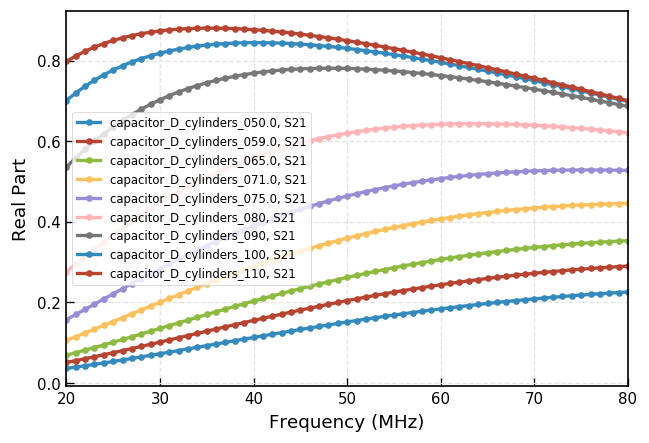

In [5]:
f_band = '20-80 MHz'
axes = capas_set[f_band].plot_s_re(m=1, n=0, lw=2, marker='o')
plt.gcf().savefig('capas_set_S21db.png', dpi=150)

## Interpolating capacitor networks to intermediate capacitance values

The `NetworkSet` container can be used to interpolate a network based on the set of other networks. For example, s-parameters values are deduced at a given frequency to intermediate values of the $D_{cylinders}$ geometrical parameter.

In [6]:
# reference S11 and S21 from full-wave modelling 
freq = '50 MHz'
S11s = [ntw.s[:,0,0] for ntw in capas_set[freq]]
S21s = [ntw.s[:,1,0] for ntw in capas_set[freq]]

In [7]:
# interpolate networks for D_cylinder every mm
Ds = np.arange(50, 110, step=1)
S11s_interp, S21s_interp = [], []
for D in Ds:
    # interpolating for the full-frequency band
    ntw = capas_set.interpolate_from_network(D_cylinders, D, 
                                             interp_kind='quadratic')
    # exporting for freq
    S11s_interp.append(ntw[freq].s[:,0,0])
    S21s_interp.append(ntw[freq].s[:,1,0])

We compare discrete points from the reference model and the interpolated ones:

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


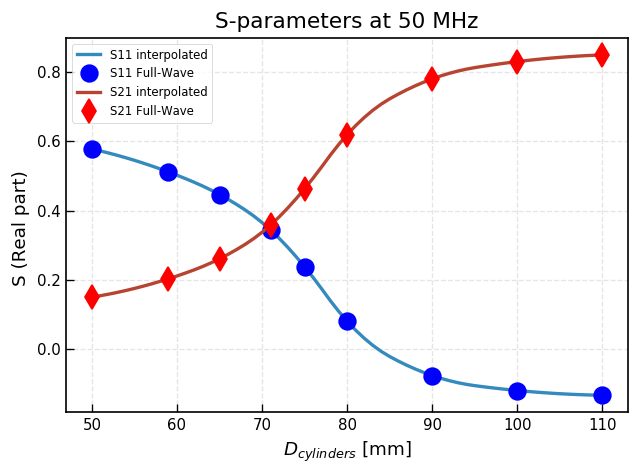

In [8]:
fig, ax = plt.subplots()
ax.plot(Ds, S11s_interp, lw=2, label='S11 interpolated')
ax.plot(D_cylinders, S11s, 'b.', ms=20, label='S11 Full-Wave')
ax.plot(Ds, S21s_interp, lw=2, label='S21 interpolated')
ax.plot(D_cylinders, S21s, 'rd', ms=10, label='S21 Full-Wave')
ax.legend()
ax.set_xlabel('$D_{cylinders}$ [mm]')
ax.set_ylabel('S (Real part) ')
ax.set_title('S-parameters at 50 MHz')
fig.savefig('S11_S21_interpolated.png', dpi=150)

Of course, the higher the number of networks in the `NetworktSet`, the better the interpolation will be.

## Extracting the capacitance values of a capacitor network

So far, we do not know the capacitance of the capacitor but only the its S-parameters vs frequency and the geometrical parameters linking the distance between capacitor electrodes. Here, we deduce an equivalent lumped-model of a capacitor network, and thus of the set of the full-wave simulated capacitors and to the interpolated ones. 

### Equivalent Lumped Model

An equivalent lumped model is proposed by the capacitor manufacturer (COMET) in the capacitor datasheet [1]. The equivalent model is a RLC circuit (in parallel with a resistance): 

![COMET Datasheet](COMET_datasheet.png)

with the capacitance $C$ tunable from 15 to 150 pF and the elements $L\leqslant 24$ nH and $R_p$ and $R_s$ in the order of 20 to 50 M$\Omega$ and 5-10 m$\Omega$ respectively. 

However in the case we consider here of the WEST ICRH antenna, the capacitor is inserted inside the antenna (as the internal conductor), surrounded by the outer conductor elements which create stray capacitances. In this situation, its turns out that the equivalent capacitance of the setup is modified (capacitance decreases w.r.t. manufacturer datasheet values) [2]. Moreover, the self inductance is also modified as the way the capacitor is connected to the inner conductor adds additional length (stray inductances).  

Thus, the proposed equivalent circuit does not match the full-wave calculation (shown in appendix) and the lumped model must be refined. 

In order to model the proximity of the outer conductor housing on each sides of the capacitor electrodes, shunt capacitances are added to the equivalent model. The propagation effects from full-wave port to the capacitor (stray transmission lines) are modeled by additional RL elements around the capacitor itself.    

![Capacitor Equivalent Circuit](capacitor_equivalent_circuit.svg)

Note that the parallel resistor $R_p$ can be neglected in the >MHz frequency range.

Assuming that $R_1=R_2$, $L_1=L_2$ and $C_1=C_2$ (to start), the network is given by the function below:

In [9]:
def eq_capa(C, R, L, R1, C1, L1):
    '''
    Equivalent lumped model of the WEST ICRH antenna capacitor.
    
    R are given in Ohm, C in pF and L in nH
    ''' 
    freq = rf.Frequency(5, 95, npoints=101, unit='MHz')
    line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
    
    pre = line.resistor(R1) ** line.inductor(L1*1e-9) ** line.shunt_capacitor(C1*1e-12)
    post= line.shunt_capacitor(C1*1e-12) ** line.resistor(R1) ** line.inductor(L1*1e-9) 
    cap = line.resistor(R) ** line.inductor(L*1e-9) ** line.capacitor(C*1e-12)
    
    return pre ** cap ** post 

The equivalent model parameters $(C, R, L, R_1, C_1, L_1)$ are fitted (least-squares) for each full-wave simulations stored in the NetworkSet:

In [10]:
def fit_capa(X, ntw_ref):
    ''' objective function to minimize '''
    C, R, L, R1, C1, L1 = X
    ntw = eq_capa(C, R, L, R1, C1, L1).interpolate(ntw_ref.frequency)
    # residuals for real and imaginary parts of both S11 and S21
    chi = np.r_[np.real(ntw.s[:,0,0])**2 - np.real(ntw_ref.s[:,0,0])**2,
                np.imag(ntw.s[:,0,0])**2 - np.imag(ntw_ref.s[:,0,0])**2,
                np.real(ntw.s[:,1,0])**2 - np.real(ntw_ref.s[:,1,0])**2,
                np.imag(ntw.s[:,1,0])**2 - np.imag(ntw_ref.s[:,1,0])**2]
    return chi

In [12]:
# frequency band in which fit the model
f_band = '10-90 MHz'
# initial guess
X0 = C_0, R_0, L_0, R1_0, C1_0, L1_0 = 20, 0.01, 24, 1, 25, 25
# physical bounds: (min, max) values for (C, R, L, R1, C1, L1)
bounds = np.c_[(1,300), (1e-2, 10), (1e-2, 1e3), 
               (1e-2, 10), (1, 1e3), (1e-2, 1e3)]
# lists to store the fitted results
sols, Rs, Ls, Cs, R1s, C1s, L1s = [], [], [], [], [], [], []
# for all full-wave networks, extract the lumped model parameters C, R, L, R1, C1, L1
for ntw_ref in tqdm(capas_set[f_band]):
    sol = scipy.optimize.least_squares(fit_capa, np.array(X0),
                                bounds=bounds, args=(ntw_ref,))
    
    C, R, L, R1, C1, L1 = sol.x
    sols.append(sol.x); Cs.append(C); Rs.append(R); Ls.append(L); R1s.append(R1); C1s.append(C1); L1s.append(L1)
    print(f'''{ntw_ref.name}: 
        C={C:.2f} pF, R={R:.4f} Ohm, L={L:.2f} nH, 
        R1={R1:.4f} Ohm, C1={C1:.2f} pF, L1={L1:.2f} nH''')

capacitor_D_cylinders_050.0: 
        C=7.25 pF, R=0.0100 Ohm, L=16.35 nH, 
        R1=0.0100 Ohm, C1=25.18 pF, L1=2.42 nH
capacitor_D_cylinders_059.0: 
        C=9.73 pF, R=0.0100 Ohm, L=24.69 nH, 
        R1=0.0100 Ohm, C1=25.81 pF, L1=2.56 nH
capacitor_D_cylinders_065.0: 
        C=12.51 pF, R=0.0100 Ohm, L=29.37 nH, 
        R1=0.0100 Ohm, C1=26.16 pF, L1=2.46 nH
capacitor_D_cylinders_071.0: 
        C=17.62 pF, R=0.0100 Ohm, L=32.37 nH, 
        R1=0.0100 Ohm, C1=26.39 pF, L1=2.17 nH
capacitor_D_cylinders_075.0: 
        C=24.14 pF, R=0.0100 Ohm, L=33.26 nH, 
        R1=0.0100 Ohm, C1=26.47 pF, L1=1.86 nH
capacitor_D_cylinders_080: 
        C=38.30 pF, R=0.0100 Ohm, L=33.13 nH, 
        R1=0.0100 Ohm, C1=26.50 pF, L1=1.49 nH
capacitor_D_cylinders_090: 
        C=73.74 pF, R=0.0100 Ohm, L=31.94 nH, 
        R1=0.0100 Ohm, C1=26.21 pF, L1=1.54 nH
capacitor_D_cylinders_100: 
        C=109.39 pF, R=0.0100 Ohm, L=31.78 nH, 
        R1=0.0100 Ohm, C1=25.86 pF, L1=1.79 nH
capacitor_D_cyl

We note that the equivalent self inductance $L_{eq}\approx 30$ nH is higher than the datasheet value ($\leq 24$ nH). This result is somewhat expected since the technique used by the manufacturer to measure the self inductance [3] is not representative of the WEST ICRH antenna configuration.  

With this set of model parameters, let's see if the model matches the full-wave reference.

## Comparing model to full-wave references

Let's see how the parameters found matches the full-wave model. In the two figures below, the thin curves correspond to the reference and the thick curves to the lumped model.

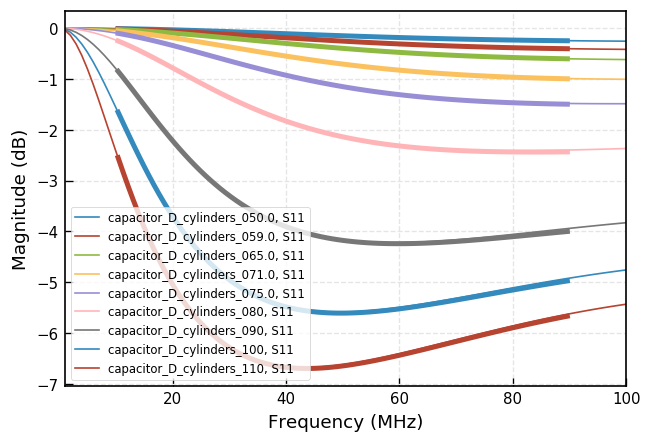

In [13]:
# compare S11
for (x, ntw_ref) in zip(sols, capas_set):
    props = next(plt.gca()._get_lines.prop_cycler)  # same color for both
    ntw_ref.plot_s_db(m=0, n=0, lw=1, c=props['color'])
    eq_capa(*x)[f_band].plot_s_db(m=0, n=0, lw=3, c=props['color'], label=None)
plt.gcf().savefig('comparison_fullwave_lumped_S11.png', dpi=150)

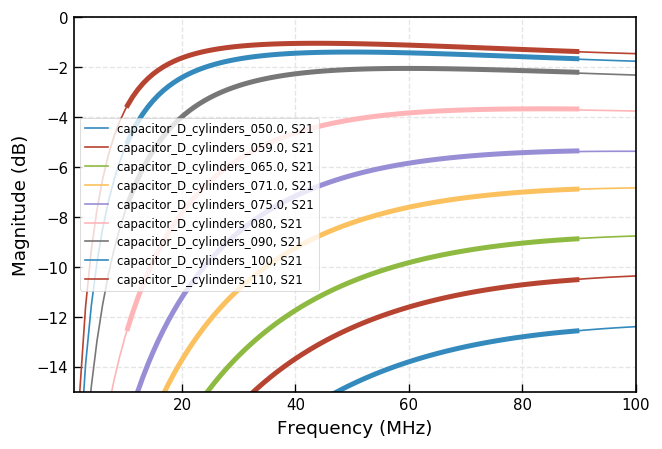

In [14]:
# compare S21
for (x, ntw_ref) in zip(sols, capas_set):
    props = next(plt.gca()._get_lines.prop_cycler)
    ntw_ref.plot_s_db(m=1, n=0, lw=1, c=props['color'])
    eq_capa(*x)[f_band].plot_s_db(m=1, n=0, lw=3, c=props['color'], label=None)
plt.gca().set_ylim(-15,0)
plt.gcf().savefig('comparison_fullwave_lumped_S21.png', dpi=150)

The equivalent model fits nice for all $D_{cylinders}$ and frequency range, even in the range for which the capacitor is no more linear w.r.t. distance between electrodes [1]. 

Let's see how much error is realized by substracting the reference networks with the model networks:

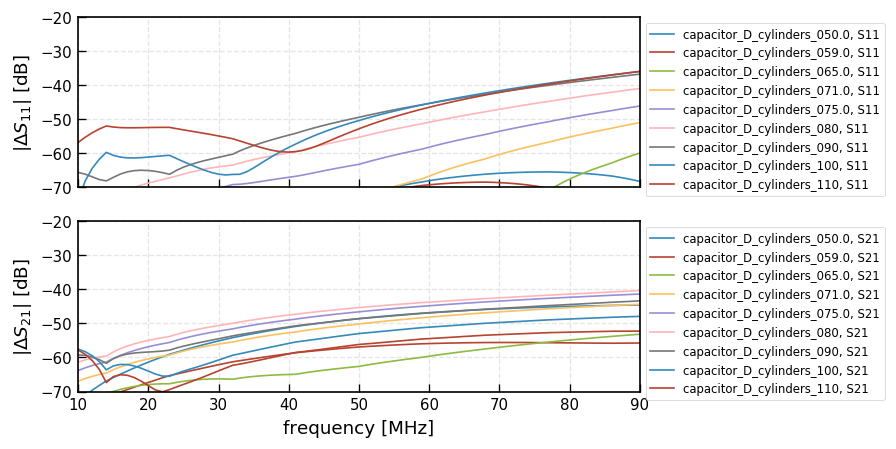

In [64]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
for (sol, ntw_ref) in zip(sols, capas_set[f_band]):
    # match the 3rd port of the full-wave results 
    # to be able to perform direct operation bwt networks
    #line = rf.media.DefinedGammaZ0(frequency=capas_set[f_band][0].frequency)
    #ntw_ref = rf.connect(ntw_ref, 2, line.match(), 0)
    # generate model network, interpolated to the same frequencies than the full-wave reference
    ntw_model = eq_capa(*sol).interpolate(ntw_ref.frequency)
    # generate error network
    ntw_error = ntw_ref - ntw_model
    # plot the error in dB
    ntw_error.plot_s_db(ax=ax1, m=0, n=0)
    ntw_error.plot_s_db(ax=ax2, m=1, n=0)
ax1.set_xlabel('')
ax2.set_xlabel('frequency [MHz]')
ax1.set_ylabel('|$\Delta S_{11}$| [dB]')
ax2.set_ylabel('|$\Delta S_{21}$| [dB]')
lgd1 = ax1.legend(bbox_to_anchor=(1,1), fontsize=7)
lgd2 = ax2.legend(bbox_to_anchor=(1,1), fontsize=7)
[ax.set_ylim(-70,-20) for ax in (ax1,ax2)]

fig.savefig('capacitor_lumped_model_error_specific_fit.png', dpi=150, bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

Error made with the lumped model is below -40 dB using specific parameters fit for each full-wave simulation. In order to get a more convenient model, let's see if we can freeze the lumped parameters but $C$. 

### Simplying further the equivalent model
If we want to simplify further the equivalent model, it would be convenient if all parameter values but $C$ could be constants. Let's look at these values:

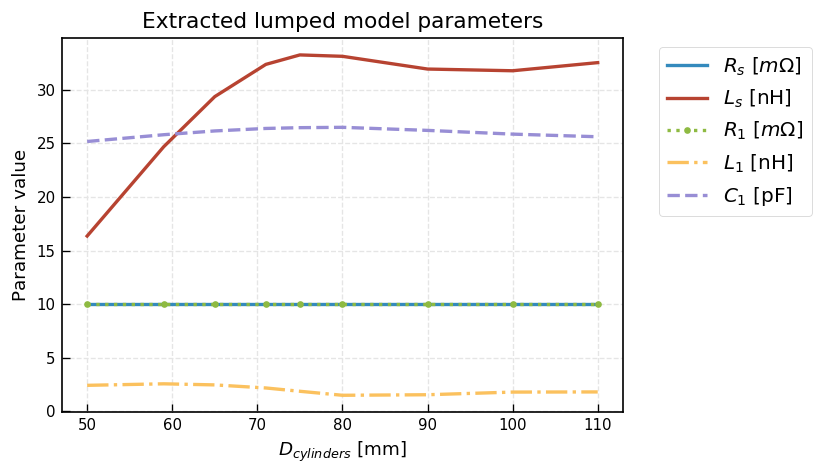

In [70]:
fig, ax = plt.subplots()
ax.plot(D_cylinders, np.array(Rs)*1e3, lw=2, label='$R_s$ [$m\Omega$]')
ax.plot(D_cylinders, Ls, lw=2, label='$L_s$ [nH]')
ax.plot(D_cylinders, np.array(R1s)*1e3, lw=2, ls=':', marker='o', label='$R_1$ [$m\Omega$]')
ax.plot(D_cylinders, L1s, lw=2, ls='-.', label='$L_1$ [nH]')
ax.plot(D_cylinders, C1s, lw=2, ls='--', label='$C_1$ [pF]')
lgd = ax.legend(fontsize=12, loc='center', bbox_to_anchor=(1.2,0.75),)
ax.set_xlabel('$D_{cylinders}$ [mm]')
ax.set_ylabel('Parameter value')
ax.set_title('Extracted lumped model parameters')
fig.savefig('capacitor_extracted_lumped_model_parameters.png', dpi=150,
            bbox_extra_artists=(lgd,), bbox_inches='tight')

 Expect for the self inductance $L_s$, all other parameters are almost constant for all values of $D_{cylinders}$. Taking the mean values (rounded to 2 decimals) for $D_{cylinders}>70$ mm:

In [17]:
# NB : the average are taken for D_cylinders > 60 mm, 
# in order to avoid the 'non-linear' range
Req = np.round(np.mean(Rs[2:-1]), decimals=2)
Leq = np.round(np.mean(Ls[2:-1]), decimals=2)
R1eq = np.round(np.mean(R1s[2:-1]), decimals=2)
C1eq = np.round(np.mean(C1s[2:-1]), decimals=2)
L1eq = np.round(np.mean(L1s[2:-1]), decimals=2)
print(f'''Req={Req:.4f} Ohm, Leq={Leq:.2f} nH, 
R1eq={R1eq:.4f} Ohm, C1eq={C1:.2f} pF, L1eq={L1:.2f} nH''')

Req=0.0100 Ohm, Leq=31.97 nH, 
R1eq=0.0100 Ohm, C1eq=25.62 pF, L1eq=1.80 nH


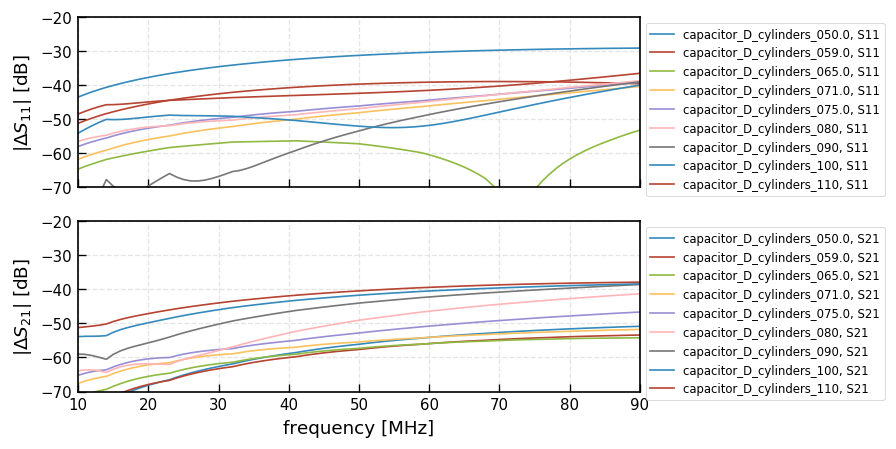

In [63]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
for (C, ntw_ref) in zip(Cs, capas_set[f_band]):
    # match the 3rd port of the full-wave results 
    # to be able to perform direct operation bwt networks
    #line = rf.media.DefinedGammaZ0(frequency=capas_set[f_band][0].frequency)
    #ntw_ref = rf.connect(ntw_ref, 2, line.match(), 0)
    # generate model network, interpolated to the same frequencies than the full-wave reference
    ntw_model = eq_capa(C, Req, Leq, R1eq, C1eq, L1eq).interpolate(ntw_ref.frequency)
    # generate error network
    ntw_error = ntw_ref - ntw_model
    # plot the error in dB
    ntw_error.plot_s_db(ax=ax1, m=0, n=0)
    ntw_error.plot_s_db(ax=ax2, m=1, n=0)
ax1.set_xlabel('')
ax2.set_xlabel('frequency [MHz]')
ax1.set_ylabel('|$\Delta S_{11}$| [dB]')
ax2.set_ylabel('|$\Delta S_{21}$| [dB]')
lgd1 = ax1.legend(bbox_to_anchor=(1,1), fontsize=7)
lgd2 = ax2.legend(bbox_to_anchor=(1,1), fontsize=7)
[ax.set_ylim(-70,-20) for ax in (ax1,ax2)]
fig.savefig('capacitor_lumped_model_error_unique_fit.png', dpi=150, bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

All errors in order of -40 dB or below with the constant parameters model. 

In conclusion, in order to model correctly the capacitor networks in an integrated model of the WEST ICRH antenna, one can either:

 - interpolate directly the s-parameters from a NetworkSet which consists in full-wave simulations of the capacitor in realistic geometry, calculated at  difference positions (capacitances), as done in [2]. In this case, the control parameter is related to a geometrical distance between the capacitor electrodes (here $D_{cylinders}$).
 - use the proposed lumped model. In this case, the driving parameter is the "real" equivalent capacitance $C$ of the assembly (which differs from the capacitance given by the manufacturer). 


## Interpolating capacitance

Now that the equivalent model is setup, let's compare the capacitance obtained from it to the manufacturer measured value (given at delivery).

Below, the capacitances are extracted (using all other lumped parameters fixed), for much more $D_{cylinders}$ points. 

In [71]:
def fit_capa_simplified(C, ntw_ref):
    ''' objective function to minimize '''
    ntw = eq_capa(C, Req, Leq, R1eq, C1eq, L1eq).interpolate(ntw_ref.frequency)
    # residuals for real and imaginary parts of both S11 and S21
    chi = np.r_[np.real(ntw.s[:,0,0])**2 - np.real(ntw_ref.s[:,0,0])**2,
                np.imag(ntw.s[:,0,0])**2 - np.imag(ntw_ref.s[:,0,0])**2,
                np.real(ntw.s[:,1,0])**2 - np.real(ntw_ref.s[:,1,0])**2,
                np.imag(ntw.s[:,1,0])**2 - np.imag(ntw_ref.s[:,1,0])**2]
    return chi

In [72]:
C0 = 50
Cs_interp = []
for D in tqdm(Ds):
    ntw_ref = capas_set[freq].interpolate_from_network(D_cylinders, D, 
                                             interp_kind='quadratic')
    sol = scipy.optimize.least_squares(fit_capa_simplified, C0,
                                args=(ntw_ref,))
    
    Cs_interp.append(sol.x)

In [73]:
# manufacturer measurement for a capacitor serial #576823
Travel = np.r_[-24.88, -19.8, -18.1, -13.6, -9.1, -4.5, 0.0,
          4.5, 9.1, 13.6, 18.1, 22.7, 26.94, 28.68]
NomCapa = np.r_[13.05, 15.02, 16.28, 20.09, 26.93, 39.12, 54.35,
               70.33, 86.7, 102.71, 118.69, 135.01, 150.06, 155.66]

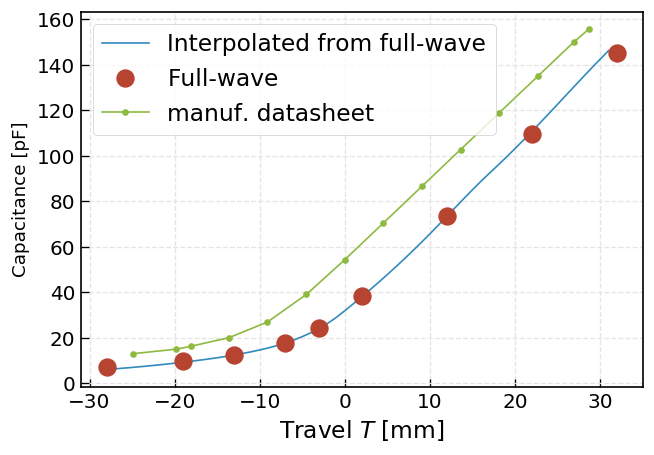

In [79]:
fig, ax = plt.subplots()
ax.plot(Ds-78, Cs_interp, label='Interpolated from full-wave')
ax.plot(np.r_[D_cylinders]-78, Cs, '.', ms=20, label='Full-wave')
ax.plot(Travel, NomCapa, 'o-', label='Manuf. datasheet')
ax.set_xlabel('Travel $T$ [mm]', fontsize=14)
ax.set_ylabel('Capacitance [pF]')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)
fig.savefig('capacitance_vs_travel.png', dpi=150)

# References

- [1] [COMET Service Bulletin-52](https://www.comet-pct.com/getmedia/fb744f1b-1125-4c91-8af3-e058fa56a3bd/SB-52_Technical_Recommendations_and_General_Instructions_for_Vacuum_Capacitors.aspx)
- [2] [W. Helou, PhD thesis, Aix-Marseille University, 2018](http://www.theses.fr/2017AIXM0395) (§5.5).
- [3] [COMET, Service Bulletin-17](https://www.comet-pct.com/getmedia/e0fdabb7-fcbd-42fa-a801-e69213e4b21f/SB-17_Measuring_of_Self_Resonance_Frequency.aspx), Measuring of Self Resonance Frequency


Other references discussing the modelling of capacitor for ICRH antennas: 

- [4] [F. Durodié et al., Plasma Phys. Control. Fusion 54, 074012 (2012)](https://iopscience.iop.org/article/10.1088/0741-3335/54/7/074012/meta).

- [5] [F. Louche et al., Fusion Eng. Des. 96–97, 508 (2015)](https://www.sciencedirect.com/science/article/pii/S0920379615000666?via%3Dihub)

- [6] [W. Helou et al., Fusion Eng. Des. 96–97, 5 (2015)](https://www.sciencedirect.com/science/article/pii/S092037961500023X?via%3Dihub).

# Appendix: using a simple RLC equivalent model
Here we show that using a simple RLC model, as proposed in manufacturer documentation, does not lead to good results. 

In [80]:
def eq_capa_simple(C, L=24):
    '''
    Simple Equivalent lumped model of the WEST ICRH antenna capacitor.
    
    R are given in Ohm, C in pF and L in nH
    ''' 
    freq = rf.Frequency(5, 95, npoints=101, unit='MHz')
    line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
    R = 1e-2
    cap = line.resistor(R) ** line.inductor(L*1e-9) ** line.capacitor(C*1e-12)
    
    return cap

The equivalent model capacitance $C$ is fitted (least-squares) for each full-wave simulations stored in the NetworkSet:

In [81]:
def fit_capa_simple(X, ntw_ref):
    ''' objective function to minimize '''
    C, L = X
    ntw = eq_capa_simple(C, L).interpolate(ntw_ref.frequency)
    # residuals for real and imaginary parts of both S11 and S21
    chi = np.r_[np.real(ntw.s[:,0,0])**2 - np.real(ntw_ref.s[:,0,0])**2,
                np.imag(ntw.s[:,0,0])**2 - np.imag(ntw_ref.s[:,0,0])**2,
                np.real(ntw.s[:,1,0])**2 - np.real(ntw_ref.s[:,1,0])**2,
                np.imag(ntw.s[:,1,0])**2 - np.imag(ntw_ref.s[:,1,0])**2]
    return chi

In [82]:
# frequency band in which fit the model
f_band = '40-60 MHz'
# initial guess
X_0 = np.array([50, 24])
# physical bounds: (min, max) values for (C, R, L, R1, C1, L1)
bounds = np.c_[(10,300), (1, 1e2)]
# lists to store the fitted results
sols_simple, Cs_simple, Ls_simple = [], [], []
# for all full-wave networks, extract the lumped model parameters C, R, L, R1, C1, L1
for ntw_ref in tqdm(capas_set[f_band]):
    sol = scipy.optimize.least_squares(fit_capa_simple, X_0,
                                bounds=bounds, args=(ntw_ref,))
    
    C, L = sol.x
    sols_simple.append(sol.x); Cs_simple.append(C); Ls_simple.append(L) 
    print(f'''{ntw_ref.name}: C={C:.2f} pF, L={L:.2f} nH''')

capacitor_D_cylinders_050.0: C=24.80 pF, L=1.00 nH
capacitor_D_cylinders_059.0: C=26.83 pF, L=1.00 nH
capacitor_D_cylinders_065.0: C=28.71 pF, L=1.00 nH
capacitor_D_cylinders_071.0: C=31.69 pF, L=1.00 nH
capacitor_D_cylinders_075.0: C=35.19 pF, L=1.00 nH
capacitor_D_cylinders_080: C=42.69 pF, L=1.00 nH
capacitor_D_cylinders_090: C=59.91 pF, L=1.00 nH
capacitor_D_cylinders_100: C=71.15 pF, L=1.00 nH
capacitor_D_cylinders_110: C=77.34 pF, L=1.00 nH


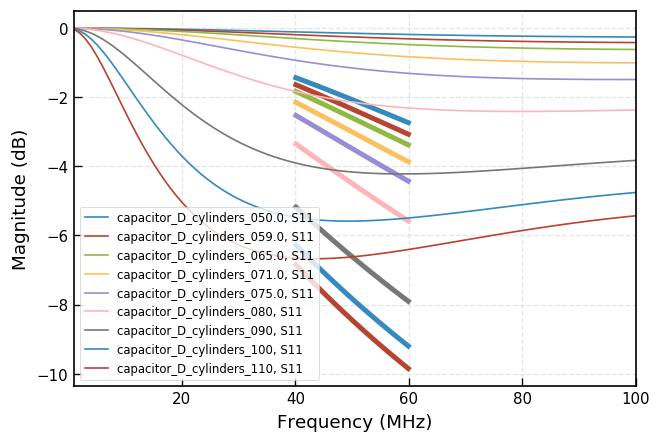

In [86]:
# compare S11
for ((C, L), ntw_ref) in zip(sols_simple, capas_set):
    props = next(plt.gca()._get_lines.prop_cycler)  # same color for both
    ntw_ref.plot_s_db(m=0, n=0, lw=1, c=props['color'])
    eq_capa_simple(C, L)[f_band].plot_s_db(m=0, n=0, lw=3, c=props['color'], label=None)

(-15, 0)

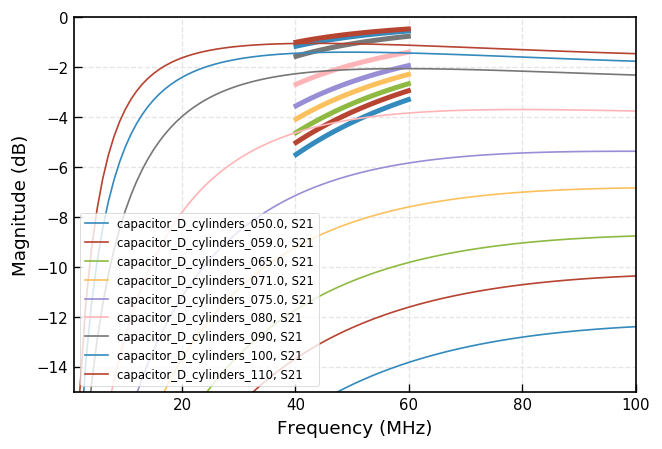

In [88]:
# compare S21
for ((C,L), ntw_ref) in zip(sols_simple, capas_set):
    props = next(plt.gca()._get_lines.prop_cycler)
    ntw_ref.plot_s_db(m=1, n=0, lw=1, c=props['color'])
    eq_capa_simple(C, L)[f_band].plot_s_db(m=1, n=0, lw=3, c=props['color'], label=None)
plt.gca().set_ylim(-15,0)

Some styling!

In [89]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """

   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style('custom.css')